# Preprocessing Dual Energy Carbonate CT Data

Before running the Monte Carlo inversion, we need to perform some pre-configurations. 
In this tutorial, we will process this data directly within the Jupyter Notebook, 
in a parallel MPI environment using [ipyparallel](https://ipyparallel.readthedocs.io/).

Let's first create a cluster with a set of 5 MPI engines:

In [1]:
import ipyparallel as ipp

# Create an MPI cluster with 5 engines
cluster = ipp.Cluster(engines="mpi", n=4)

# Start and connect to the cluster
rc = cluster.start_and_connect_sync()

# Enable IPython magics for parallel processing
rc[:].activate()

Starting 4 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


  0%|          | 0/4 [00:00<?, ?engine/s]

This will enable the `%%px` 
[cell magic](https://ipyparallel.readthedocs.io/en/latest/examples/Parallel%20Magics.html#px-cell-magic), 
which allows RockVerse to perform parallel processing interactively within this Jupyter notebook.

Let's create the dual energy group and import the 
[raw images we downloaded from the Digital Rocks Portal](../sample_data/import_C04B21_dualenergy.ipynb):

In [2]:
%%px --block --group-outputs=type

import rockverse as rv
import matplotlib.pyplot as plt
from IPython.display import display


C04B21_Raw100keV =  rv.voxel_image.import_raw(
    rawfile='/estgf_dados/P_D/GOB7/testemunhos/C04B21Raw100keV.raw',
    store='/estgf_dados/P_D/GOB7/testemunhos/C04B21Raw100keV.zarr',
    shape=(512, 512, 738),               #<- From metadata, image size
    chunks=(256, 256, 369),              #<- Our choice of chunk size will give a 2x2x2 chunk grid
    dtype='<i2',                         #<- From metadata, little-endian 16-bit signed integer
    offset=0,                            #<- From metadata
    voxel_length=(0.488, 0.488, 1.25),   #<- From metadata
    voxel_unit='mm',                     #<- From metadata
    raw_file_order='F',                  #<- Fortran file order
    field_name='Low attenuation',        #<- Our choice for field name (X-ray attenuation)
    field_unit='H.U.',                   #<- field units (Hounsfield units)
    description='Low energy X-ray CT attenuation',
    overwrite=True,                       #<- Overwrite if file exists in disk
    )

C04B21_Raw140keV =  rv.voxel_image.import_raw(
    rawfile='/estgf_dados/P_D/GOB7/testemunhos/C04B21Raw140keV.raw',
    store='/estgf_dados/P_D/GOB7/testemunhos/C04B21Raw140keV.zarr',
    shape=(512, 512, 738),               #<- From metadata, image size
    chunks=(256, 256, 369),              #<- Our choice of chunk size will give a 2x2x2 chunk grid
    dtype='<i2',                         #<- From metadata, little-endian 16-bit signed integer
    offset=0,                            #<- From metadata
    voxel_length=(0.488, 0.488, 1.25),   #<- From metadata
    voxel_unit='mm',                     #<- From metadata
    raw_file_order='F',                  #<- Fortran file order
    field_name='High attenuation',       #<- Our choice for field name (X-ray attenuation)
    field_unit='H.U.',                   #<- field units (Hounsfield units)
    description='High energy X-ray CT attenuation',
    overwrite=True                       #<- Overwrite if file exists in disk
    )


%px:   0%|          | 0/4 [00:00<?, ?tasks/s]

[stdout:0] [2025-02-13 11:34:19] (Low attenuation) Importing raw file: 100% 8/8 [00:02<00:00,  3.18chunk/s]
[2025-02-13 11:34:23] (High attenuation) Importing raw file: 100% 8/8 [00:02<00:00,  3.82chunk/s]


In [4]:
%%px --block --group-outputs=type

# Create the Dual Energy CT group
dectgroup = rv.dualenergyct.create_group(
    store='/estgf_dados/P_D/GOB7/testemunhos/C04B21_DGX',
    overwrite=True)


%px:   0%|          | 0/4 [00:00<?, ?tasks/s]

In [5]:
%%px --block --group-outputs=type

# Copy the low energy CT image
dectgroup.copy_image(
    image=rv.open('/estgf_dados/P_D/GOB7/testemunhos/C04B21Raw100keV.zarr'),
    name='lowECT',
    overwrite=True,
    #chunks=(100, 100, 100)
    )

# Copy the high energy CT image
dectgroup.copy_image(
    image=rv.open('/estgf_dados/P_D/GOB7/testemunhos/C04B21Raw140keV.zarr'),
    name='highECT',
    overwrite=True,
    #chunks=(100, 100, 100)
    )

[stdout:0] [2025-02-13 11:40:18] Copying: 100% 8/8 [00:04<00:00,  1.81chunk/s]
[2025-02-13 11:40:24] Copying: 100% 8/8 [00:04<00:00,  1.84chunk/s]


%px:   0%|          | 0/4 [00:00<?, ?tasks/s]

Now, let's take a quick look at the data using the orthogonal viewer:

[stdout:0] [2025-02-13 11:40:29] Histogram Low attenuation (min/max): 100% 8/8 [00:00<00:00, 14.47chunk/s]
[2025-02-13 11:40:30] Histogram Low attenuation (counting voxels): 100% 8/8 [00:02<00:00,  2.96chunk/s]
[2025-02-13 11:40:37] Histogram High attenuation (min/max): 100% 8/8 [00:00<00:00, 16.51chunk/s]
[2025-02-13 11:40:39] Histogram High attenuation (counting voxels): 100% 8/8 [00:01<00:00,  6.29chunk/s]


%px:   0%|          | 0/4 [00:00<?, ?tasks/s]

[output:0]

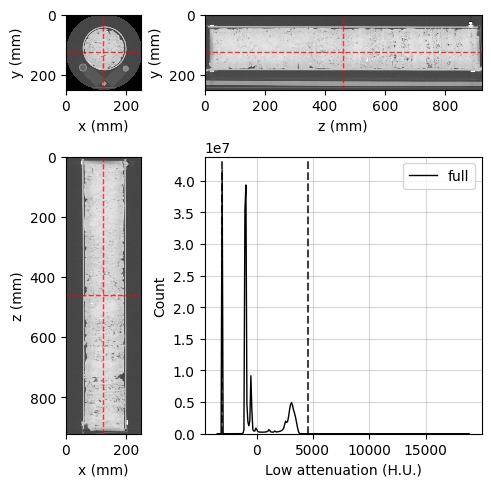

[output:0]

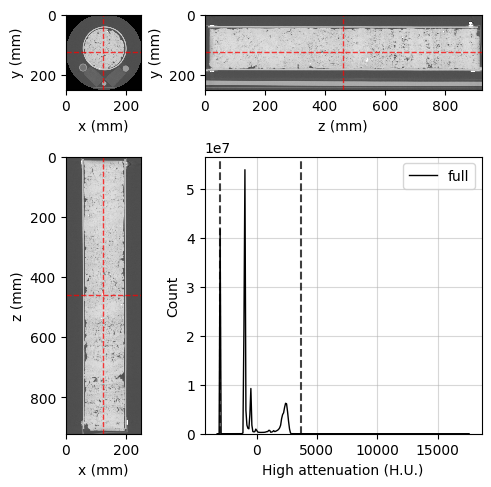

In [6]:
%%px --block

import matplotlib.pyplot as plt
from IPython.display import display

# Create orthogonal viewers for low and high energy images
lowE_viewer = rv.OrthogonalViewer(image=dectgroup.lowECT)
highE_viewer = rv.OrthogonalViewer(image=dectgroup.highECT)

#Each process will create it's own repeated image, let's close all but rank zero:
if rv.config.mpi_rank != 0:
    plt.close(lowE_viewer.figure)
    plt.close(highE_viewer.figure)


## Building the segmentation image


A segmentation image is needed to inform RockVerse about the spatial location of the standard materials.
While the segmentation image is not available in the Digital Rocks Portal, the rock sample and the standard 
materials are fairly aligned with the image's z-axis. Let's quickly build a segmentation image with 
RockVerse's cylindrical regions. 
A little trial and error is all it takes in this case:

### Air

%px:   0%|          | 0/4 [00:00<?, ?tasks/s]

[stdout:0] [2025-02-13 11:41:09] Histogram High attenuation (min/max): 100% 8/8 [00:00<00:00,  9.49chunk/s]
[2025-02-13 11:41:11] Histogram High attenuation (counting voxels): 100% 8/8 [00:00<00:00, 18.73chunk/s]


[output:0]

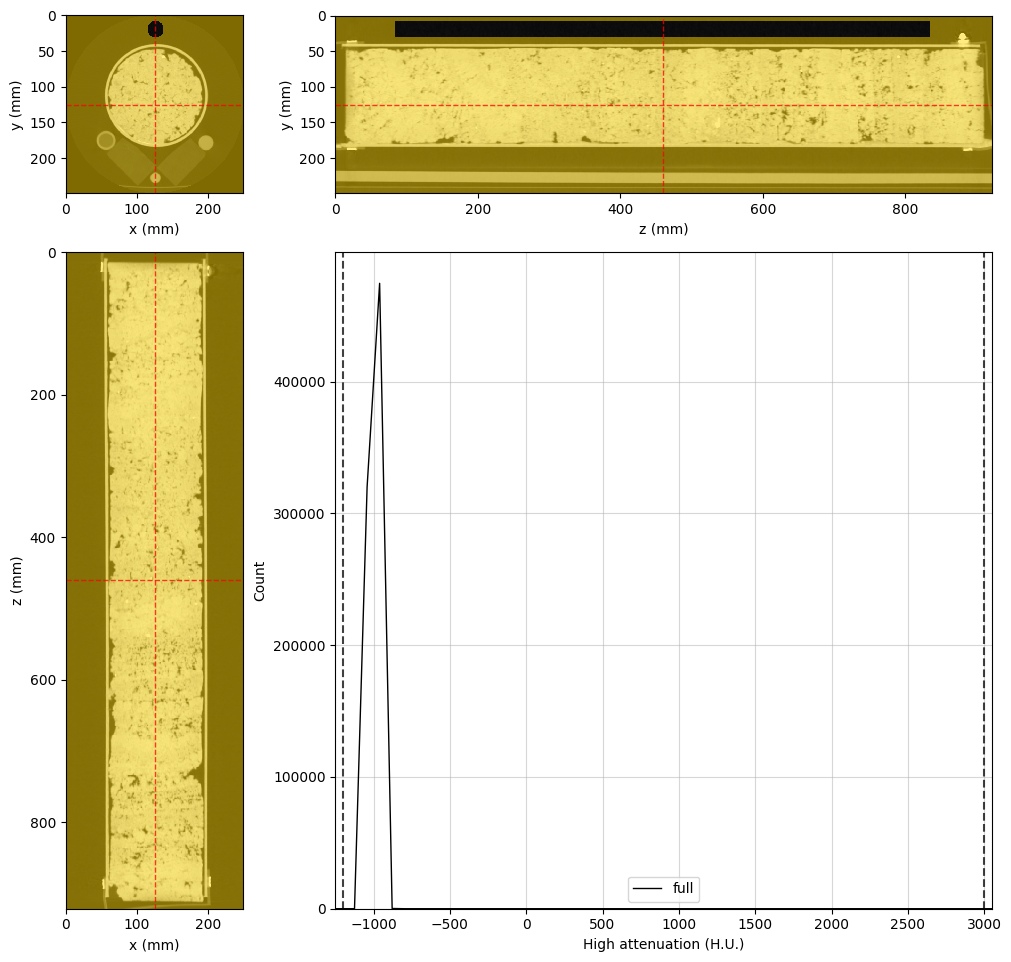

In [8]:
%%px --block --group-outputs=type

#Adjusting viewer properties will help us in this task
highE_viewer.figure.set_size_inches(10, 10)
highE_viewer.update_image_dict(clim=(-1200, 3000))
highE_viewer.mask_color = 'gold'
highE_viewer.mask_alpha = 0.5

#This is the final cylindrical region for probing air attenuation
air_region = rv.region.Cylinder(p=(126, 20, 461), v=(0, 0, 1), r=10, l=750)

# Set the region in the viewer and visualize the result
highE_viewer.region = air_region

#Changing region rebuilds the histogram. Let's set the scale again
highE_viewer.ax_histogram.set_xlim(-1250, 3050)

# Only display the figure for rank 0
if rv.config.mpi_rank == 0:
    display(highE_viewer.figure)

### Water

[stdout:0] [2025-02-13 11:41:17] Histogram High attenuation (min/max): 100% 8/8 [00:00<00:00,  9.88chunk/s]
[2025-02-13 11:41:19] Histogram High attenuation (counting voxels): 100% 8/8 [00:00<00:00, 17.26chunk/s]


%px:   0%|          | 0/4 [00:00<?, ?tasks/s]

[output:0]

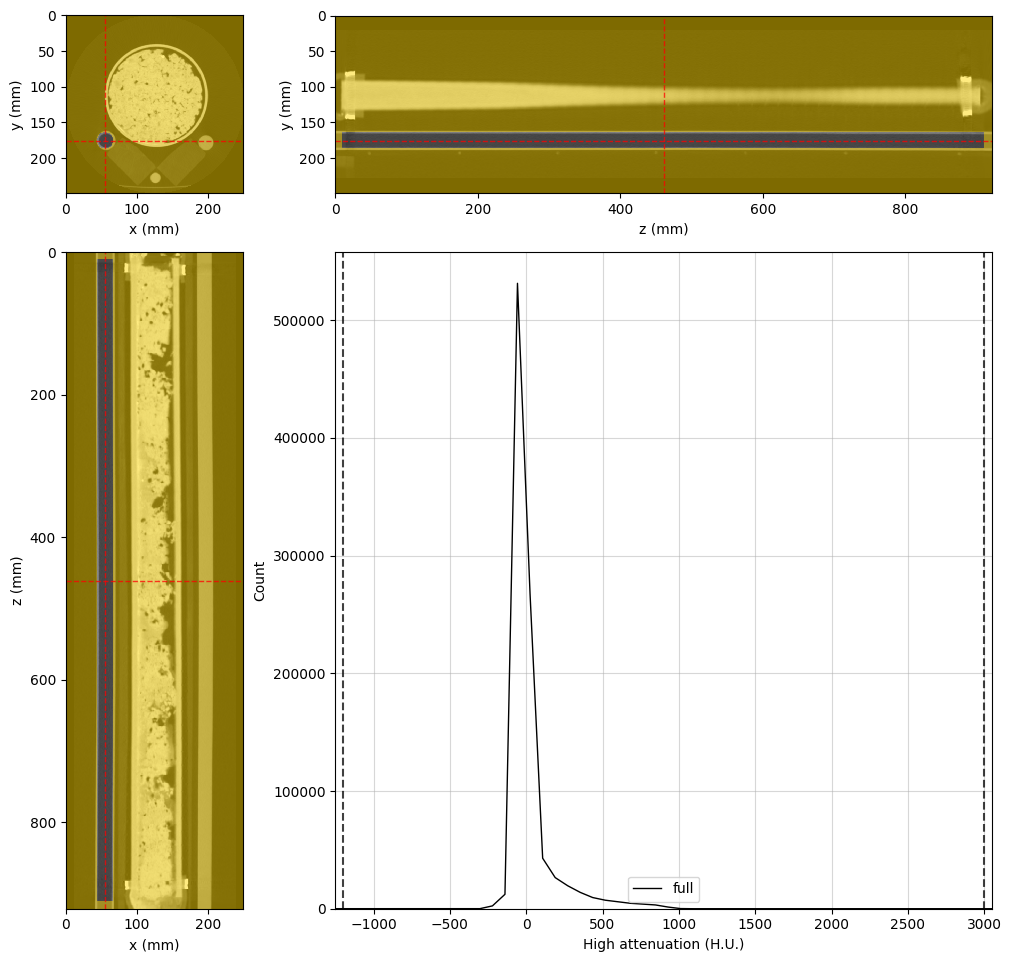

In [9]:
%%px --block --group-outputs=type

#Final water region
water_region = rv.region.Cylinder(p=(55, 176.2, 461), v=(0, 0, 1), r=10, l=900)

#Adjust the viewer and display for rank 0
highE_viewer.region = water_region
highE_viewer.ref_point = water_region.p
highE_viewer.ax_histogram.set_xlim(-1250, 3050)

if rv.config.mpi_rank == 0:
    display(highE_viewer.figure)

### Teflon

[stdout:0] [2025-02-13 11:41:24] Histogram High attenuation (min/max): 100% 8/8 [00:00<00:00, 10.02chunk/s]
[2025-02-13 11:41:26] Histogram High attenuation (counting voxels): 100% 8/8 [00:00<00:00, 18.93chunk/s]


%px:   0%|          | 0/4 [00:00<?, ?tasks/s]

[output:0]

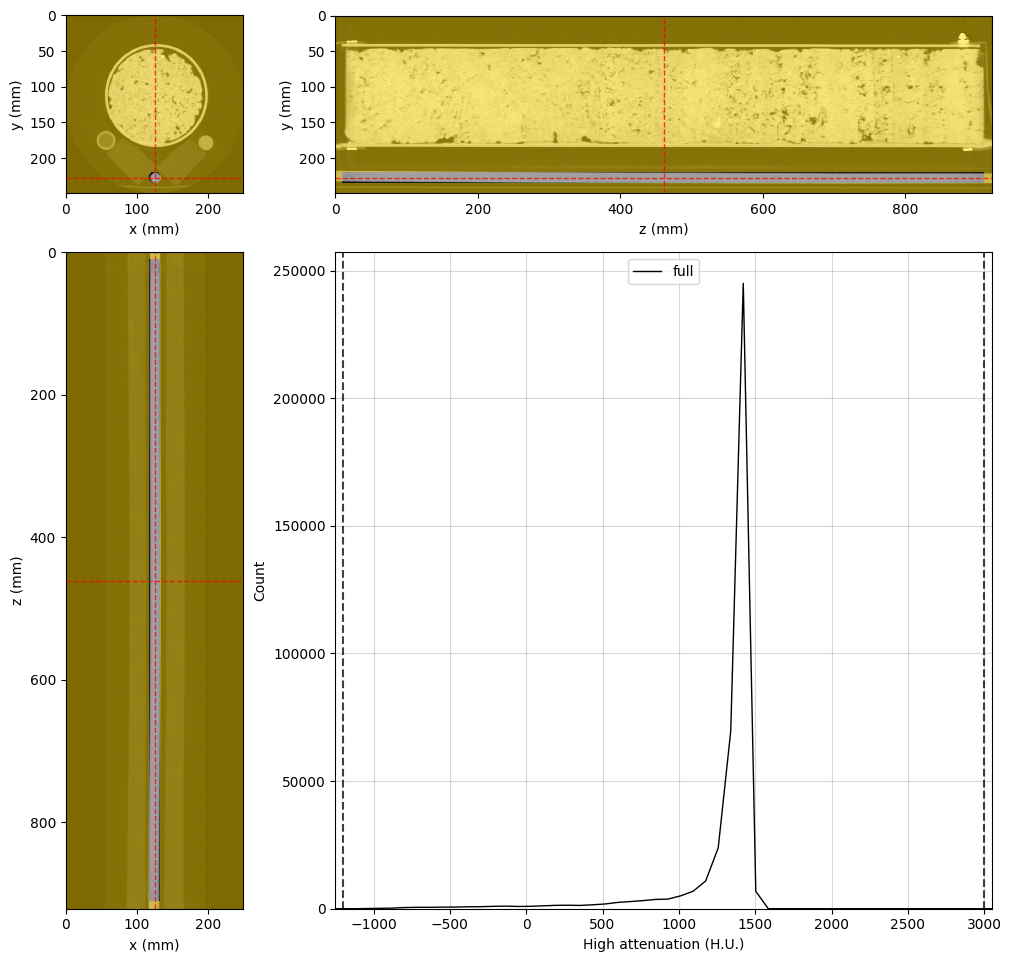

In [10]:
%%px --block --group-outputs=type

#Final teflon region
teflon_region = rv.region.Cylinder(p=(124.7, 228, 461), v=(0, 0, 1), r=6.5, l=900)

#Adjust the viewer and display for rank 0
highE_viewer.region = teflon_region
highE_viewer.ref_point = teflon_region.p
highE_viewer.ax_histogram.set_xlim(-1250, 3050)

if rv.config.mpi_rank == 0:
    display(highE_viewer.figure)

### Silica

[stdout:0] [2025-02-13 11:41:34] Histogram High attenuation (min/max): 100% 8/8 [00:00<00:00,  9.85chunk/s]
[2025-02-13 11:41:36] Histogram High attenuation (counting voxels): 100% 8/8 [00:00<00:00, 17.10chunk/s]


%px:   0%|          | 0/4 [00:00<?, ?tasks/s]

[output:0]

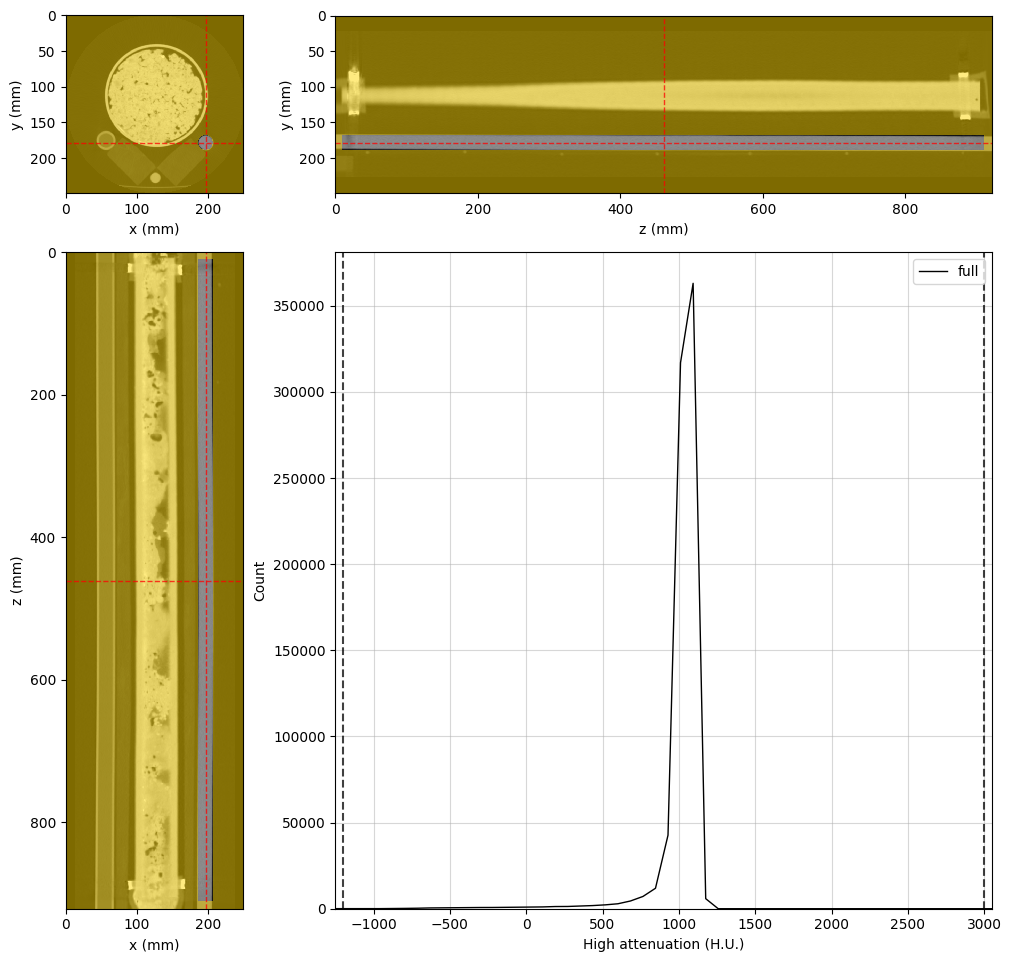

In [11]:
%%px --block --group-outputs=type

#Final silica region
silica_region = rv.region.Cylinder(p=(196, 179, 461), v=(0, 0, 1), r=9, l=900)

#Adjust the viewer and display for rank 0
highE_viewer.region = silica_region
highE_viewer.ref_point = silica_region.p
highE_viewer.ax_histogram.set_xlim(-1250, 3050)

if rv.config.mpi_rank == 0:
    display(highE_viewer.figure)

### Rock sample

[stdout:0] [2025-02-13 11:41:44] Histogram High attenuation (min/max): 100% 8/8 [00:00<00:00, 10.09chunk/s]
[2025-02-13 11:41:46] Histogram High attenuation (counting voxels): 100% 8/8 [00:00<00:00,  8.73chunk/s]


%px:   0%|          | 0/4 [00:00<?, ?tasks/s]

[output:0]

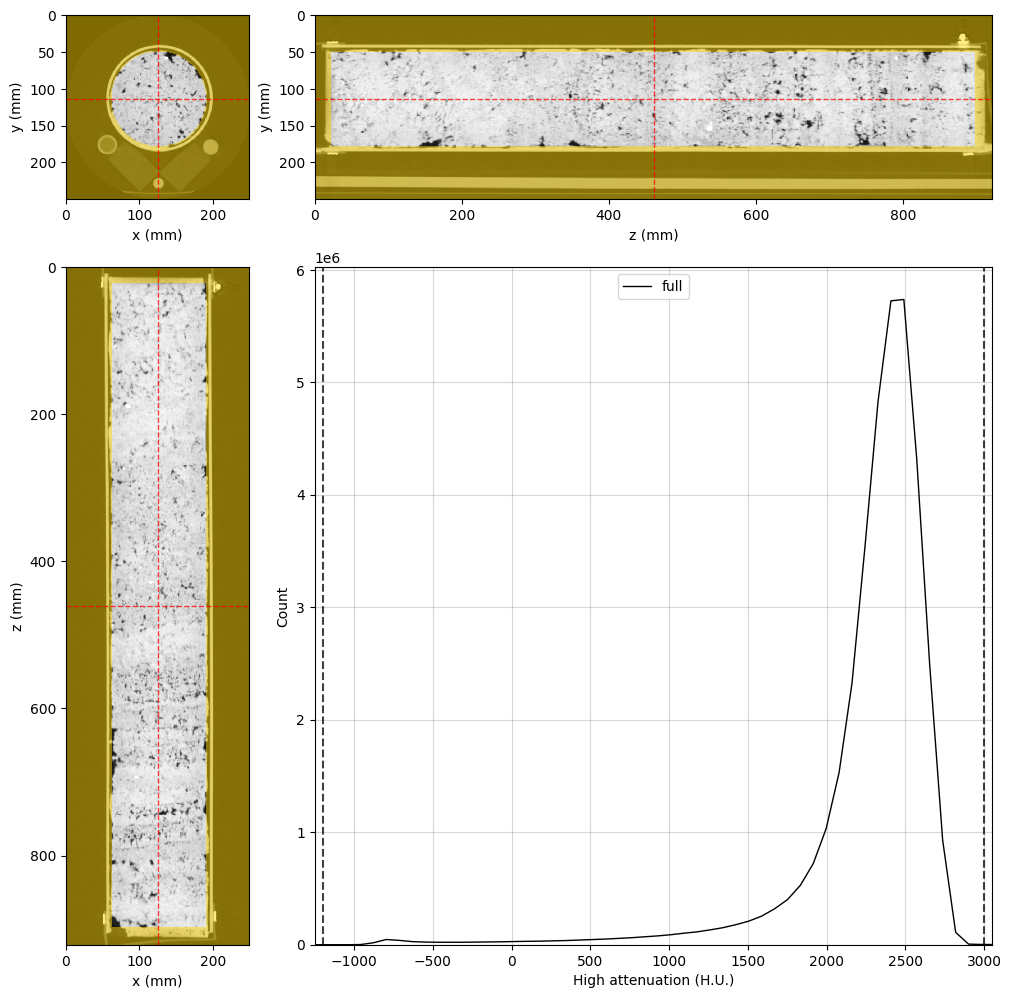

In [12]:
%%px --block --group-outputs=type

#Final rock region
rock_region = rv.region.Cylinder(p=(126, 114, 461), v=(0, 0, 1), r=63, l=875)

#Adjust the viewer and display for rank 0
highE_viewer.region = rock_region
highE_viewer.ref_point = rock_region.p
highE_viewer.ax_histogram.set_xlim(-1250, 3050)

if rv.config.mpi_rank == 0:
    display(highE_viewer.figure)

### Combined segmentation image

Now, we can use these regions to create the final segmentation image:

[stdout:0] [2025-02-13 11:41:56] (segmentation) Set: 100% 8/8 [00:02<00:00,  3.70chunk/s]
[2025-02-13 11:41:59] (segmentation) Set: 100% 8/8 [00:00<00:00, 14.10chunk/s]
[2025-02-13 11:41:59] (segmentation) Set: 100% 8/8 [00:00<00:00, 14.04chunk/s]
[2025-02-13 11:42:00] (segmentation) Set: 100% 8/8 [00:00<00:00, 13.52chunk/s]
[2025-02-13 11:42:01] (segmentation) Set: 100% 8/8 [00:00<00:00, 13.22chunk/s]
[2025-02-13 11:42:02] Histogram High attenuation (min/max): 100% 8/8 [00:00<00:00, 28.47chunk/s]
[2025-02-13 11:42:02] Histogram High attenuation (counting voxels): 100% 8/8 [00:01<00:00,  6.00chunk/s]
[2025-02-13 11:42:06] Histogram High attenuation (min/max): 100% 8/8 [00:00<00:00, 28.06chunk/s]
[2025-02-13 11:42:07] Histogram High attenuation (reading segmentation): 100% 8/8 [00:00<00:00, 48.68chunk/s]
[2025-02-13 11:42:08] Histogram High attenuation (counting voxels): 100% 8/8 [00:01<00:00,  4.15chunk/s]


%px:   0%|          | 0/4 [00:00<?, ?tasks/s]

[output:0]

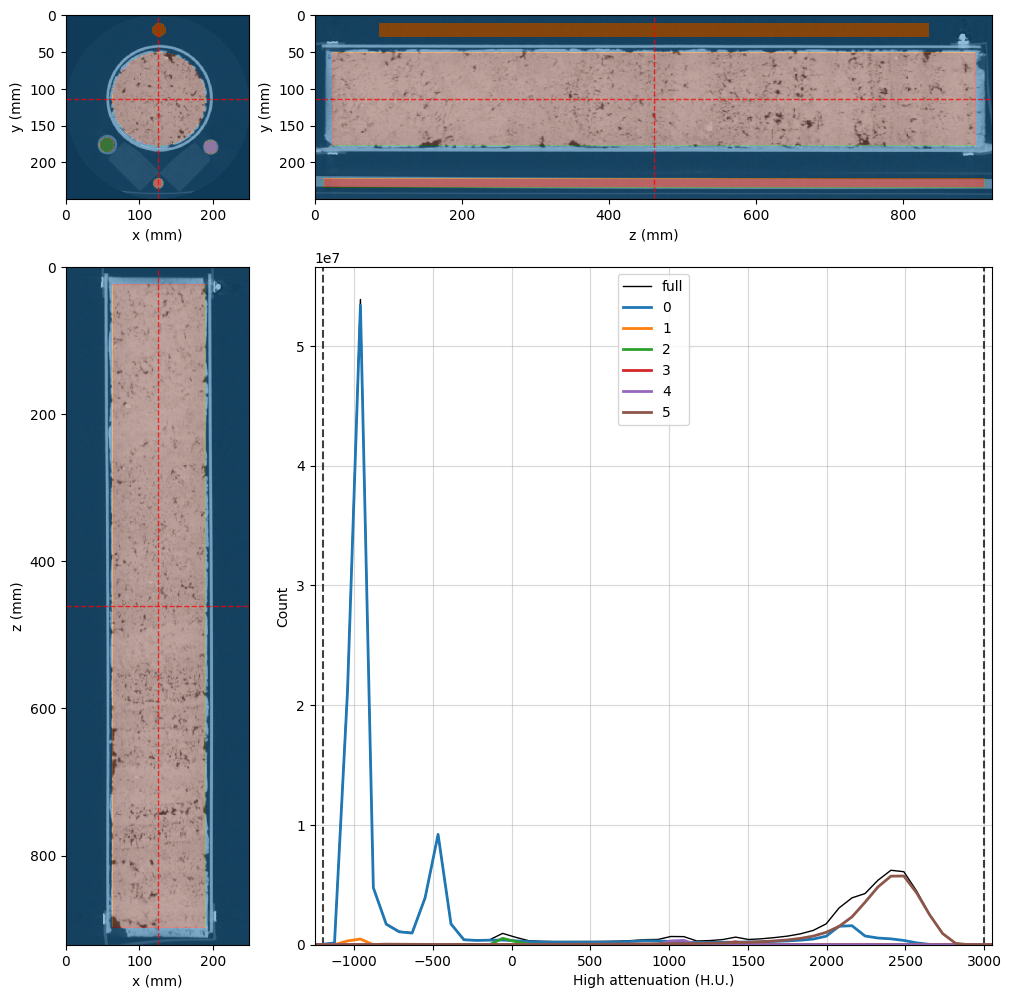

In [13]:
%%px --block --group-outputs=type

# Create the segmentation voxel image inside the dual energy group
dectgroup.create_segmentation(fill_value=0, overwrite=True)

# Use the VoxelImage math method to assign each region
dectgroup.segmentation.math(value=1, op='set', region=air_region)    #Air
dectgroup.segmentation.math(value=2, op='set', region=water_region)  #Water
dectgroup.segmentation.math(value=3, op='set', region=teflon_region) #Teflon
dectgroup.segmentation.math(value=4, op='set', region=silica_region) #Silica
dectgroup.segmentation.math(value=5, op='set', region=rock_region)   #Rock sample

#Adjust the viewer and display for rank 0
highE_viewer.region = None
highE_viewer.segmentation = dectgroup.segmentation
highE_viewer.ref_point = rock_region.p
highE_viewer.ax_histogram.set_xlim(-1250, 3050)

if rv.config.mpi_rank == 0:
    display(highE_viewer.figure)

## Mask Image

It is a good practice to save time in the Monte Carlo inversion by masking out voxels for which we are not interested 
in the results. While we cannot assign regions to DualEnergyCT groups, we can create an arbitrary mask voxel image to 
inform RockVerse which voxels should be ignored. In our case, phase 0 in our segmentation image represents the regions 
we want to exclude from our inversion:

[stdout:0] [2025-02-13 11:42:19] (mask) Set: 100% 8/8 [00:00<00:00,  9.14chunk/s]
[2025-02-13 11:42:21] Histogram High attenuation (min/max): 100% 8/8 [00:00<00:00, 12.12chunk/s]
[2025-02-13 11:42:22] Histogram High attenuation (reading segmentation): 100% 8/8 [00:00<00:00, 143.70chunk/s]
[2025-02-13 11:42:22] Histogram High attenuation (counting voxels): 100% 8/8 [00:00<00:00,  9.49chunk/s]


%px:   0%|          | 0/4 [00:00<?, ?tasks/s]

[output:0]

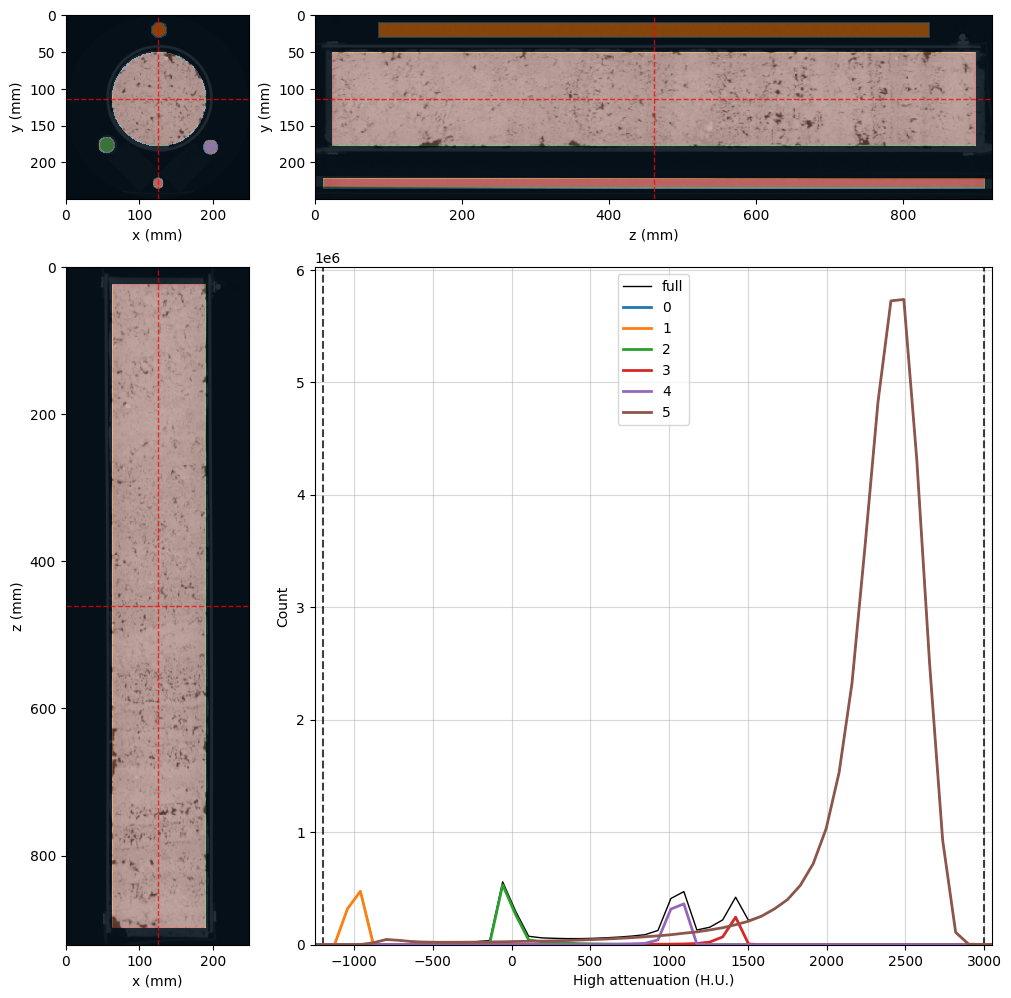

In [14]:
%%px --block --group-outputs=type

#Create the empty mask
dectgroup.create_mask(fill_value=False, overwrite=True)

#Use VoxelImage math method to set mask to True where segmentation is 0
dectgroup.mask.math(value=True,
                    op='set',
                    segmentation=dectgroup.segmentation,
                    phases=(0,))

#Adjust the viewer and display for rank 0
highE_viewer.mask = dectgroup.mask
highE_viewer.mask_color = 'k'
highE_viewer.mask_alpha = 0.75
highE_viewer.ax_histogram.set_xlim(-1250, 3050)

if rv.config.mpi_rank == 0:
    display(highE_viewer.figure)


The black voxels in the image above will be ignored during the Monte Carlo inversion.

Now that we are satisfied with the segmentation and mask, we need to calculate a more detailed 
histogram, as the histogram counts will serve as the basis for calculating the probability
density functions for the X-ray attenuation values in the standard materials. 
Once again, some testing led to the final choice of $2^{10}$ bins.

Let's update our viewer one last time:

[stdout:0] [2025-02-13 11:43:11] Histogram High attenuation (min/max): 100% 8/8 [00:00<00:00, 15.79chunk/s]
[2025-02-13 11:43:12] Histogram High attenuation (reading segmentation): 100% 8/8 [00:00<00:00, 125.57chunk/s]
[2025-02-13 11:43:12] Histogram High attenuation (counting voxels): 100% 8/8 [00:01<00:00,  4.78chunk/s]


%px:   0%|          | 0/4 [00:00<?, ?tasks/s]

[output:0]

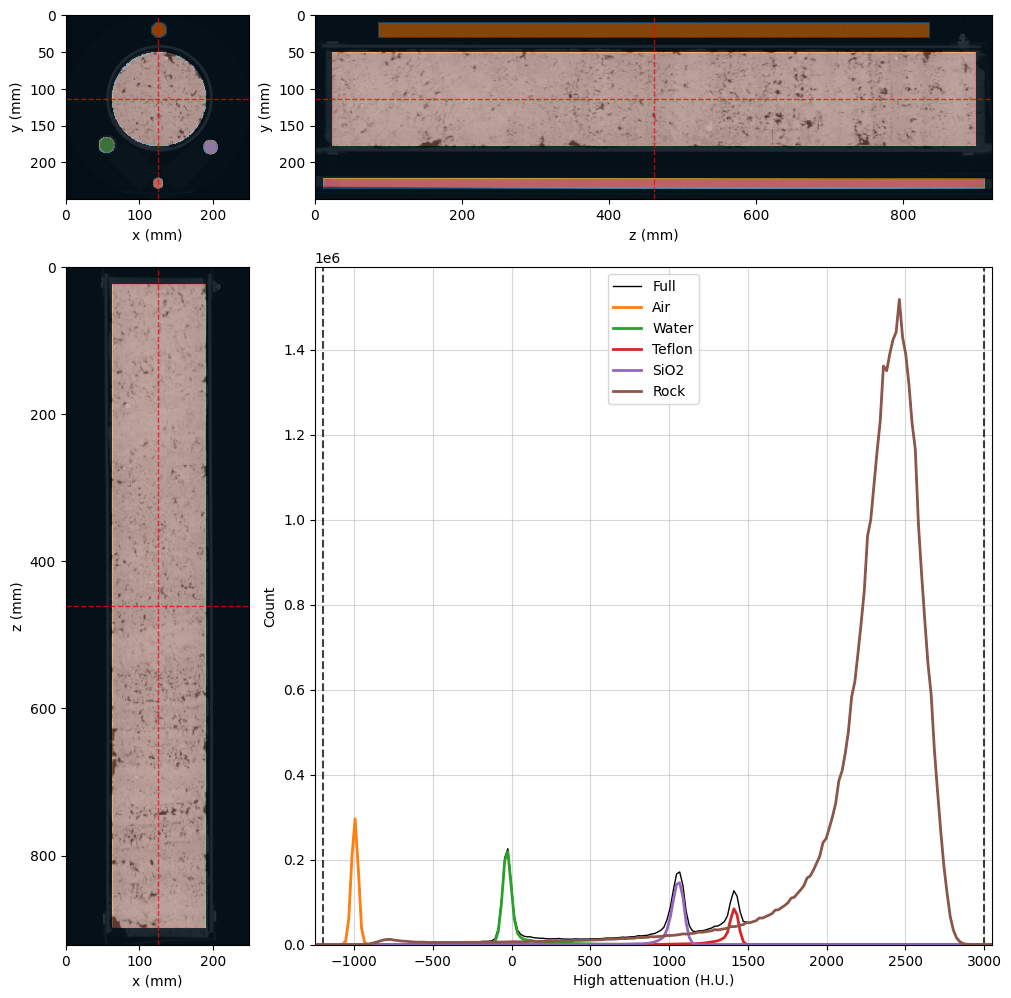

In [15]:
%%px --block --group-outputs=type

#Set the number of histogram bins
highE_viewer.histogram_bins = 2**10

#Fix the scale, as the histogram was rebuilt
highE_viewer.ax_histogram.set_xlim(-1250, 3050)

#Write the material names in the histogram legend
highE_viewer.ax_histogram.legend(
    [
        highE_viewer.histogram_lines['full'],
        highE_viewer.histogram_lines['1'],
        highE_viewer.histogram_lines['2'],
        highE_viewer.histogram_lines['3'],
        highE_viewer.histogram_lines['4'],
        highE_viewer.histogram_lines['5'],
    ], [
        'Full',
        'Air',
        'Water',
        'Teflon',
        'SiO2',
        'Rock'
    ]
)

#Show figure for rank 0
if rv.config.mpi_rank == 0:
    display(highE_viewer.figure)

## Run the preprocessing step

Now we are ready to set the processing parameters and run the pre-processing step.
Our little cluster with 5 MPI processes is still enough for this task.

In [ ]:
%%px --block --group-outputs=type

# Set the number of histogram bins as previously decided
dectgroup.histogram_bins = 2**10

# Fill in the calibration materials dictionaries

dectgroup.calibration_material0['description'] = 'Air'
dectgroup.calibration_material0['segmentation_phase'] = 1
dectgroup.calibration_material0['lowE_gaussian_center_bounds'] = [-1100, -900]
dectgroup.calibration_material0['highE_gaussian_center_bounds'] = [-1100, -900]

dectgroup.calibration_material1['description'] = 'Water'
dectgroup.calibration_material1['segmentation_phase'] = 2
dectgroup.calibration_material1['composition'] = {'H': 2, 'O': 1}
dectgroup.calibration_material1['bulk_density'] = 1
dectgroup.calibration_material1['lowE_gaussian_center_bounds'] = [-100, 100]
dectgroup.calibration_material1['highE_gaussian_center_bounds'] = [-100, 100]

dectgroup.calibration_material2['description'] = 'SiO2'
dectgroup.calibration_material2['segmentation_phase'] = 3
dectgroup.calibration_material2['composition'] = {'Si': 1, 'O': 2}
dectgroup.calibration_material2['bulk_density'] = 2.2
dectgroup.calibration_material2['lowE_gaussian_center_bounds'] = [1550, 1700]
dectgroup.calibration_material2['highE_gaussian_center_bounds'] = [1300, 1500]

dectgroup.calibration_material3['description'] = 'Teflon'
dectgroup.calibration_material3['segmentation_phase'] = 4
dectgroup.calibration_material3['composition'] = {'C': 2, 'F': 4}
dectgroup.calibration_material3['bulk_density'] = 2.2
dectgroup.calibration_material3['lowE_gaussian_center_bounds'] = [800, 1300]
dectgroup.calibration_material3['highE_gaussian_center_bounds'] = [800, 1300]

# Call the preprocess method
dectgroup.preprocess()

#NAO_ESTA_GERANDO_TODOS___MONTE_DE_1

%px:   0%|          | 0/4 [00:00<?, ?tasks/s]

[stdout:0] [2025-02-13 12:00:21] Hashing Low attenuation: 100% 8/8 [00:00<00:00, 19.79chunk/s]
[2025-02-13 12:00:21] Hashing High attenuation:  12% 1/8 [00:00<00:01,  4.92chunk/s]

Received Keyboard Interrupt. Sending signal SIGINT to engines...


Controller stopped: {'exit_code': 0, 'pid': 3705181, 'identifier': 'ipcontroller-1739457232-ux8o-3705135'}
Output for ipengine-1739457232-ux8o-1739457234-3705135:
   1940         with zarr.config.set({'array.order': 'C'}):

File /estgf_dados/P_D/GOB7/mambaforge/envs/rockverse-zarr3/lib/python3.12/contextlib.py:158, in _GeneratorContextManager.__exit__(self, typ, value, traceback)
    156     value = typ()
    157 try:
--> 158     self.gen.throw(value)
    159 except StopIteration as exc:
    160     # Suppress StopIteration *unless* it's the same exception that
    161     # was passed to throw().  This prevents a StopIteration
    162     # raised inside the "with" statement from being suppressed.
    163     return exc is not value

File ~/rockverse/src/rockverse/errors.py:49, in collective_only_rank0_runs()
     47 if error_msg:
     48     name, msg = error_msg.split(':')[0].strip(), ''.join(error_msg.split(':')[1:]).strip()
---> 49     collective_raise(CustomCollectiveException(na

## Appraisal

Let's take a look at the preprocessing results. 
This time, we will work locally instead of in the ipyparallel cluster,
so we need to load the libraries and the DECT group again.


In [ ]:
# Note that we are not using the %%px cell magic anymore!
# Now the process will run locally, so we nee to start over

import matplotlib.pyplot as plt
import numpy as np
import rockverse as rv

#Load the DECT group
dectgroup = rv.open('/estgf_dados/P_D/GOB7/testemunhos/C04B21_DGX')

The results can be accessed through the following attributes:

- ``calibration_gaussian_coefficients``: histogram fitting parameters,
- ``lowEhistogram``: a Pandas DataFrame with the histogram values for the low energy image,
- ``highEhistogram``: a Pandas DataFrame with the histogram values for the high energy image.

Let's take a look at each one of them:


In [ ]:
print(dectgroup.calibration_gaussian_coefficients)

In [ ]:
print(dectgroup.lowEhistogram)

In [ ]:
print(dectgroup.highEhistogram)

In [ ]:
print(dectgroup.lowE_inversion_coefficients)

In [ ]:
print(dectgroup.highE_inversion_coefficients)

Let's write some code to retrieve these parameters and display some plots:

In [ ]:
def gaussian(x, A, mu, sigma):
    return A*np.exp(-0.5*((x-mu)/sigma)**2)

fig1, ax1 = plt.subplots(2, 2, layout='constrained')
fig2, ax2 = plt.subplots(2, 2, layout='constrained')
fig1.suptitle('Low Energy Attenuation')
fig2.suptitle('High Energy Attenuation')

for hist, ax, mode in zip((dectgroup.lowEhistogram, dectgroup.highEhistogram),
                          (ax1, ax2),
                          ('low', 'high')):

    for k, (i, j, xlb) in enumerate(zip((0, 0, 1, 1),
                                        (0, 1, 0, 1),
                                        ('Air', 'Water', 'Teflon', 'Silica'))):
        ax[i][j].plot(hist['bin_centers'], hist[str(k+1)], '.', label='Hist.')

        xlim = dectgroup.__getattribute__(f'calibration_material{k}')[f'{mode}E_gaussian_center_bounds']
        xlim[0] -= 200
        xlim[1] += 200

        x = np.linspace(*xlim, 500)
        y = gaussian(
            x,
            A=dectgroup.calibration_gaussian_coefficients[f'A_{mode}E'].iloc[k],
            mu=dectgroup.calibration_gaussian_coefficients[f'mu_{mode}E'].iloc[k],
            sigma=dectgroup.calibration_gaussian_coefficients[f'sigma_{mode}E'].iloc[k])

        ax[i][j].plot(x, y, color='orange', label='Fit')
        ax[i][j].set_xlim(*xlim)
        ax[i][j].set_xlabel(xlb)
        ax[i][j].set_ylabel('Count')
        ax[i][j].legend()


In [ ]:
def gaussian_pdf(x, mu, sigma):
    return 1/np.sqrt(2*np.pi)/sigma*np.exp(-0.5*((x-mu)/sigma)**2)

fig1, ax1 = plt.subplots(2, 2, layout='constrained')
fig2, ax2 = plt.subplots(2, 2, layout='constrained')
fig1.suptitle('Monte Carlo Low Energy Attenuation')
fig2.suptitle('Monte Carlo High Energy Attenuation')


for ax, coef, mode in zip((ax1, ax2),
                          (dectgroup.lowE_inversion_coefficients,
                           dectgroup.highE_inversion_coefficients),
                           ('low', 'high')):
    for k, (i, j, xlb) in enumerate(zip((0, 0, 1, 1),
                                        (0, 1, 0, 1),
                                        ('Air', 'Water', 'Teflon', 'Silica'))):
        ax[i][j].hist(coef[f'CT_{k}'],
                    bins=25,
                    density=True,
                    facecolor='powderblue',
                    edgecolor='slategrey',
                    label='Hist.')

        ax[i][j].set_xlabel(xlb)
        ax[i][j].set_ylabel('pdf')
        x = np.linspace(*ax[i][j].get_xlim(), 100)
        mu = dectgroup.calibration_gaussian_coefficients[f'mu_{mode}E'].iloc[k],
        sigma = dectgroup.calibration_gaussian_coefficients[f'sigma_{mode}E'].iloc[k]
        y = gaussian_pdf(x, mu, sigma)
        ax[i][j].plot(x, y, color='orange', label='pdf')


In [ ]:
fig1, axs = plt.subplots(2, 3, layout='constrained')
ax1 = axs[0][0], axs[0][1], axs[0][2]
ax2 = axs[1][0], axs[1][1], axs[1][2]
fig1.suptitle('Monte Carlo $Z_{eff}$ histograms')

for ax, coef, mode in (zip((ax1, ax2),
                           (dectgroup.lowE_inversion_coefficients,
                            dectgroup.highE_inversion_coefficients),
                            ('low', 'high'))):
    for k, xlb in enumerate(('Water', 'Teflon', 'Silica')):
        ax[k].hist(coef[f'Z_{k+1}'],
                    bins=25,
                    density=True,
                    facecolor='powderblue',
                    edgecolor='slategrey',
                    label='Hist.')
        ax[k].set_xlabel(f'{xlb}, {mode}E')
        ax[k].set_ylabel('count')


In [ ]:
fig1, axs = plt.subplots(2, 3, layout='constrained')
ax1 = axs[0][0], axs[0][1], axs[0][2]
ax2 = axs[1][0], axs[1][1], axs[1][2]
fig1.suptitle('Monte Carlo Inversion parameters')

for ax, coef, mode in (zip((ax1, ax2),
                           (dectgroup.lowE_inversion_coefficients,
                            dectgroup.highE_inversion_coefficients),
                            ('low', 'high'))):
    for k, xlb in enumerate(('A', 'B', 'n')):
        ax[k].hist(coef[f'{xlb}'],
                    bins=25,
                    density=True,
                    facecolor='powderblue',
                    edgecolor='slategrey',
                    label='Hist.')
        ax[k].set_xlabel(f'{xlb}, {mode}E')
        ax[k].set_ylabel('count')

## Run the Monte Carlo inversion

Once we are satisfied with these inversion parameters, we are ready to run the full inversion. 
For this, we only need to execute the following code snippet in a parallel environment:

```python
import rockverse as rv
dectgroup = rv.open(r'/path/to/dual_energy_ct/C04B21')
dectgroup.run()
```

Remember: we are utilizing Monte Carlo in the Digital Rock universe! This process is
computationally intensive and is meant to be run in a high-performance computing environment,
such as a GPU-enabled machine or a handful of nodes in a CPU cluster. If you just want to test
the inversion, you can go back to the mask definition and reduce the cylinder length to
allow the code to work only on a tiny part of the whole image.

After completion, you will have access to the Monte Carlo results through the
following new voxel images as attributes of dectgroup:

- ``rho_min``: Voxel image with the minimum electron density per voxel.
- ``rho_p25``: Voxel image with the the first quartile for the electron density per voxel.
- ``rho_p50``: Voxel image with the the median values for the electron density per voxel.
- ``rho_p75``: Voxel image with the the third quartile for the electron density per voxel.
- ``rho_max``: Voxel image with the maximum electron density per voxel.
- ``Z_min``: Voxel image with the minimum effective atomic number per voxel.
- ``Z_p25``: Voxel image with the the first quartile for the effective atomic number per voxel.
- ``Z_p50``: Voxel image with the the median values for the effective atomic number per voxel.
- ``Z_p75``: Voxel image with the the third quartile for the effective atomic number per voxel.
- ``Z_max``: Voxel image with the maximum effective atomic number per voxel.
- ``valid``: Voxel image with the number of valid Monte Carlo results for each voxel.